In [1]:
import glets.raytrace as rt
import glets.gbd as gf
import glets.utils as ut
import numpy as np
import matplotlib.pyplot as plt
import poppy

# Testing ArbitraryWFE Ray Transfer Matrix

These have been analytically derived for representing Zernike polynomials which we will show here for some N number of Zernikes. We are interested in representing wavefronte error from errors in optical polishing that result in coupling of starlight onto the image plane via the Talbot effect, but they can't easily be represented by polynomials. Instead, we consider the mathematics of the ArbitraryWFE ray transfer matrix and use it to compute the derivatives of the surface numerically

## Test 1: Trefoil PSF
I want to make a figure that has 3 PSFs on the top. (Left) is the PSF computed with analytical derivatives, (Middle) is the PSF computed with numerical derivatives, (Right) is the FFT PSF of the same wavefront error. (Below) is a comparison of the azimuthal average of each PSF. This case is for a 1" F/10 optic

Time to compute exponential  706.628230041  s


<Figure size 432x288 with 0 Axes>

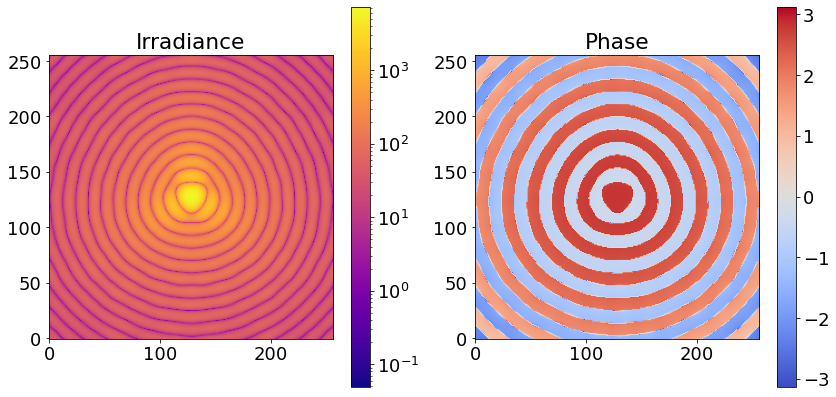

In [2]:
# Set up some parameters
nrays_across = 99
scale = 1e-2
detector_size = 5e-4
wlen = 2.2e-6
npix = 256
size = 25.4e-3

# Set up rays
rays = rt.makerays(size, nrays_across,circle=False)

# Give rays some wavefront error
testrays = rt.ZernikeWFE(nrays_across, size,rays,6,scale) # testing astig
nrays_total = int((rays.shape[1]))

# Set up a thin lens that goes to focus
lens = rt.ThinLens(254e-3, nrays_total)
dist = rt.FreeSpace(254e-3, nrays_total)
rayt = rt.matmultlist(dist, lens)

raysincirc = testrays[:,testrays[0,:]**2 + testrays[1,:]**2 <= 12.7e-3**2]
rtmincirc  = rayt[:,:,testrays[0,:]**2 + testrays[1,:]**2 <= 12.7e-3**2]
efie_analytic = np.reshape(gf.eval_gausfield(raysincirc, rtmincirc, wlen, detector_size, npix),[npix,npix])
ut.amp_phase_plot(efie_analytic,logintensity=True)

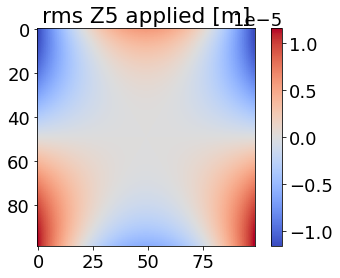

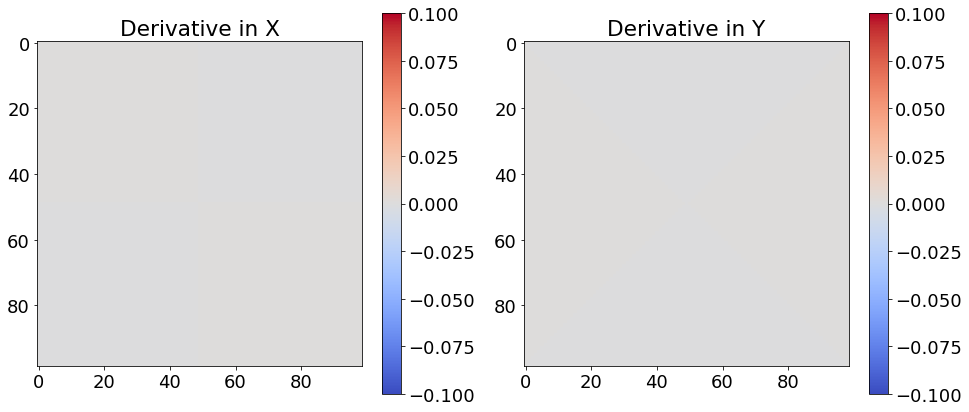

Time to compute exponential  734.879144333  s


<Figure size 432x288 with 0 Axes>

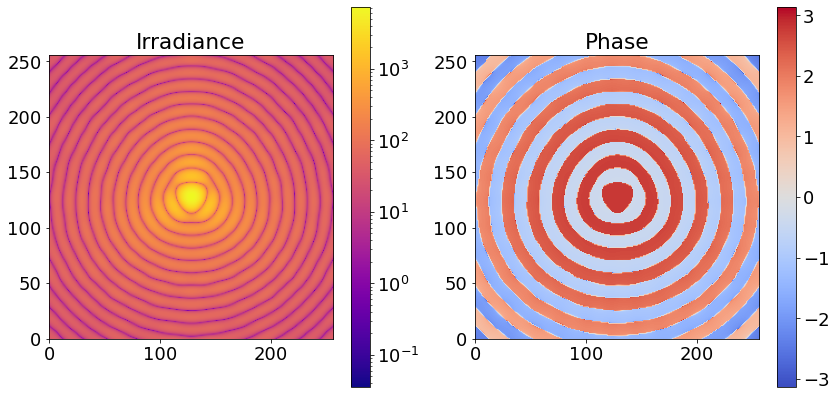

In [3]:
# Set up rays
nrays_across = 99
scale = 1e-2
detector_size = 5e-4
wlen = 2.2e-6
npix = 256
size = 25.4e-3
rays = rt.makerays(25.4e-3, nrays_across,circle=False)
scale = 1e-2

# Give rays some wavefront error
testrays = rt.ArbitraryWFE(nrays_across, size,rays,scale,zern_index=6) # testing astig
nrays_total = int((rays.shape[1]))

# Set up a thin lens that goes to focus
lens = rt.ThinLens(254e-3, nrays_total)
dist = rt.FreeSpace(254e-3, nrays_total)
rayt = rt.matmultlist(dist, lens)

raysincirc = testrays[:,testrays[0,:]**2 + testrays[1,:]**2 <= 12.7e-3**2]
rtmincirc  = rayt[:,:,testrays[0,:]**2 + testrays[1,:]**2 <= 12.7e-3**2]
efie_numerical = np.reshape(gf.eval_gausfield(raysincirc, rtmincirc, wlen, detector_size, npix),[npix,npix])
ut.amp_phase_plot(efie_numerical,logintensity=True)

<Figure size 432x288 with 0 Axes>

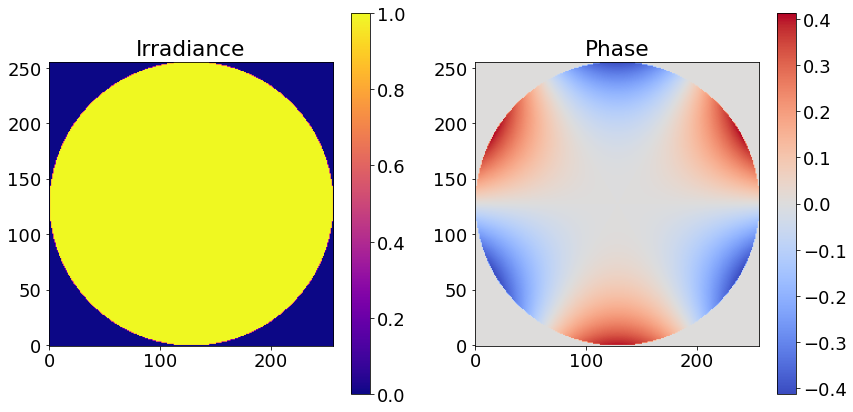

In [19]:
# scale = ~14e-2 for the case in spyder testrays.py
size = 25.4e-3
array = np.zeros([npix,npix],dtype='complex128')
x = np.linspace(-size/2,size/2,npix)
x,y = np.meshgrid(x,x)
array[np.sqrt(x**2 + y**2) <= size/2] = 1
wvfnt_error = np.sqrt(8)*(3*x**2*y - y**3)*2.5e-2
array *= np.exp(1j*2*np.pi/wlen * wvfnt_error)

ut.amp_phase_plot(array,logintensity=False)

efie_fourier = ut.zeropadft(array,8)


<Figure size 432x288 with 0 Axes>

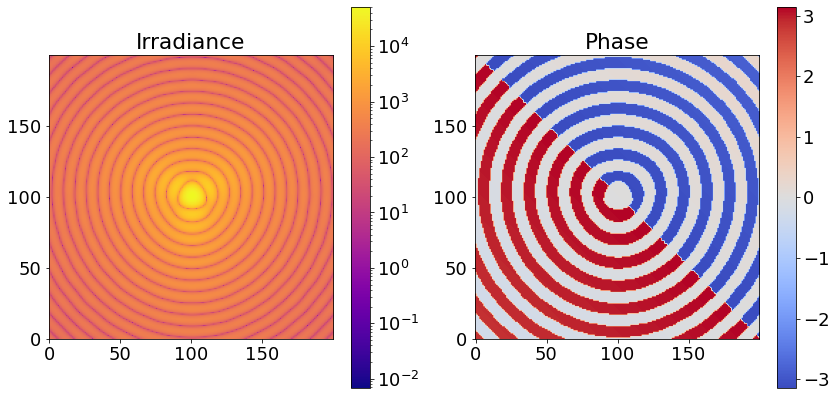

In [20]:
from matplotlib.colors import LogNorm
field_fourier = ut.grab_center(efie_fourier,100)
ut.amp_phase_plot(field_fourier,logintensity=True)

/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_65311/1175789390.py:13: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cbar_map = ax[0].imshow(np.abs(efie_analytic),norm=LogNorm(),vmin=vmin,vmax=vmax)
/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_65311/1175789390.py:14: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax[1].imshow(np.abs(efie_numerical),norm=LogNorm(),vmin=vmin,vmax=vmax)
/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_65311/1175789390.py:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases late

<Figure size 432x288 with 0 Axes>

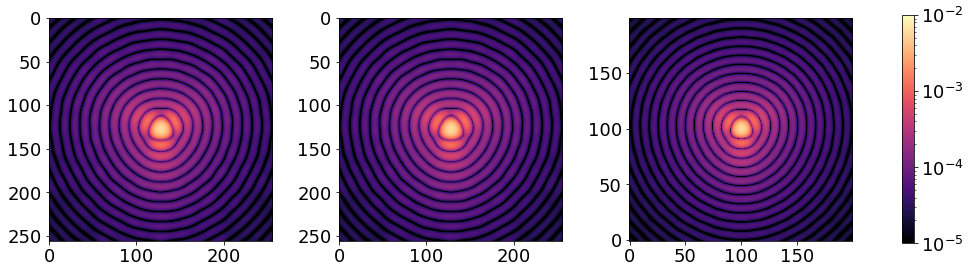

In [21]:
# Set up comparison figure

# normalize by input energy
field_fourier /= np.sum(field_fourier)
efie_numerical /= np.sum(efie_numerical)
efie_analytic /= np.sum(efie_analytic)
vmin = 1e-5
vmax = 1e-2

plt.set_cmap('magma')
fig,ax = plt.subplots(ncols=3,figsize=[18,7],gridspec_kw={"width_ratios":[1,1,1]})
fig.subplots_adjust(wspace=.3)
cbar_map = ax[0].imshow(np.abs(efie_analytic),norm=LogNorm(),vmin=vmin,vmax=vmax)
ax[1].imshow(np.abs(efie_numerical),norm=LogNorm(),vmin=vmin,vmax=vmax)
ax[2].imshow(np.abs(field_fourier)*5e-1,norm=LogNorm(),vmin=vmin,vmax=vmax,origin='lower')
#cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7],axes='off')
fig.colorbar(cbar_map,ax=ax[0:3],shrink=0.6)
plt.show()

In [16]:
test = np.array([[1,2,3],
                 [4,5,6],
                 [7,8,9]])

In [17]:
np.ravel(test)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
np.reshape(test,[3,3])

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])